In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import tensorflow as tf
from torchvision import transforms
import random
from collections import defaultdict
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [2]:
folder_path = 'dataset-acne'

In [3]:
# data generator without augmentation (with normalization)
train_datagen = ImageDataGenerator(rescale=1./255)  # only normalization
val_test_datagen = ImageDataGenerator(rescale=1./255)  # only normalization

# data generator for each dataset
train_generator = train_datagen.flow_from_directory(
    'train',  # directory for training data
    target_size=(150, 150),  # resize images to 150x150
    batch_size=32,
    class_mode='categorical'  # multi-class classification
)

val_generator = val_test_datagen.flow_from_directory(
    'validation',  # directory for validation data
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    'test',  # directory for test data
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 1668 images belonging to 5 classes.
Found 481 images belonging to 5 classes.
Found 173 images belonging to 5 classes.


In [4]:

# Load pre-trained MobileNetV2 without the classification layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer

# Create the final model
modelM = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
modelM.compile(optimizer=RMSprop(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary (optional)
modelM.summary()

C:\Users\Envy\AppData\Local\Temp\ipykernel_18400\779927752.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 150, 150, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 75, 75, 32)        │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 75, 75, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 75, 75, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 75, 75, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 75, 75, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 75, 75, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 75, 75, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 75, 75, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 75, 75, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 75, 75, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 75, 75, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 77, 77, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 38, 38, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,587,205 (9.87 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# function to gradually reduce learning rate after a certain number of epochs
def lr_schedule(epoch, lr):
    if epoch > 15:
        return lr * 0.5  # reduce learning rate by half after 15 epochs
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# train the model with training and validation generators
history = modelM.fit(
    train_generator,
    epochs=50,  # set 50 epochs
    validation_data=val_generator,
    callbacks=[lr_scheduler, early_stopping]  # use both LearningRateScheduler and EarlyStopping
)

C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.3773 - loss: 1.5478 - val_accuracy: 0.5593 - val_loss: 1.0869 - learning_rate: 5.0000e-04
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 669ms/step - accuracy: 0.5766 - loss: 1.0175 - val_accuracy: 0.5364 - val_loss: 1.0720 - learning_rate: 5.0000e-04
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 643ms/step - accuracy: 0.6477 - loss: 0.8909 - val_accuracy: 0.6299 - val_loss: 0.9492 - learning_rate: 5.0000e-04
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 630ms/step - accuracy: 0.6955 - loss: 0.7540 - val_accuracy: 0.6403 - val_loss: 0.9069 - learning_rate: 5.0000e-04
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 616ms/step - accuracy: 0.7404 - loss: 0.6735 - val_accuracy: 0.6757 - val_loss: 0.8215 - learning_rate: 5.0000e-04
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 614ms/step - accuracy: 0.7859 - loss: 0.5981 - val_accuracy: 0.6528 - val_loss: 0.8221 - learning_rate: 5.0000e-04
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 635ms/step - accura

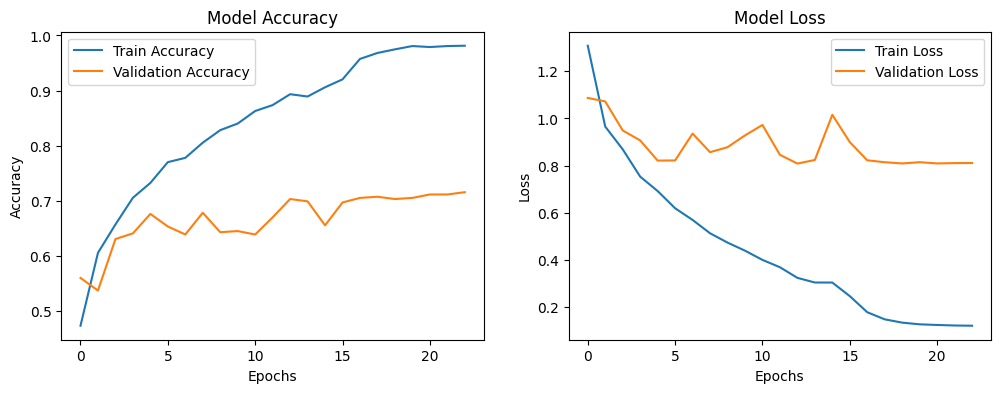

In [11]:
import matplotlib.pyplot as plt

# plot accuracy and loss
plt.figure(figsize=(12, 4))

# plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [12]:
# evaluate the model on the test data
test_loss, test_acc = modelM.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 736ms/step - accuracy: 0.7340 - loss: 0.6155
Test Accuracy: 71.25%


In [13]:
# summary of model evaluation
print("\nModel Evaluation Summary:")
print(f"Final Train Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1] * 100:.2f}%")
print(f"Final Test Accuracy: {test_acc * 100:.2f}%")


Model Evaluation Summary:
Final Train Accuracy: 98.14%
Final Validation Accuracy: 71.52%
Final Test Accuracy: 71.25%
